In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Download datasets

### Train dataset

In [4]:
train_data = pd.read_csv('data/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
y = train_data.pop('Survived')
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

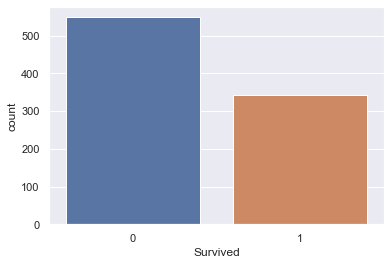

In [6]:
# target doesn't look unbalanced
sns.countplot(x = y)

### Test dataset

In [7]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data preprocessing

Get additional info fron both datasets

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Some of the features have null values. Lets check how many:

'Age' and 'Cabin' features have a lot null-values so they should be filled. 'Embarked' feature has only 2 null values so we can just remove these two rows.

In [9]:
train_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Union both train and test data to fill in null values

In [12]:
train_data['train'] = 1
test_data['train'] = 0
common_data = pd.concat([train_data, test_data], ignore_index = True)
common_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


<AxesSubplot:>

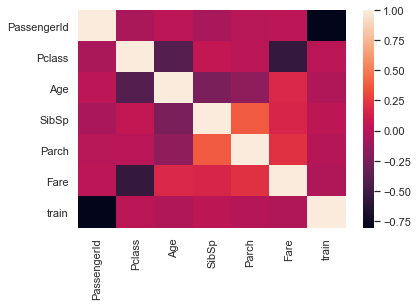

In [13]:
sns.heatmap(common_data.corr())

Remove 'PassangerId', 'Ticket' and 'Cabin' features

In [14]:
common_data.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1, inplace = True)
common_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,train
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Check histograms and boxplots

In [15]:
# categorical features
categorical_features = ['SibSp', 'Sex', 'Embarked', 'Parch', 'Pclass']

# numeric features
numeric_features = ['Age', 'Fare']

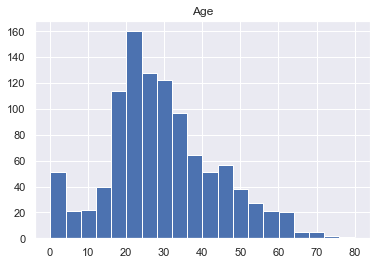

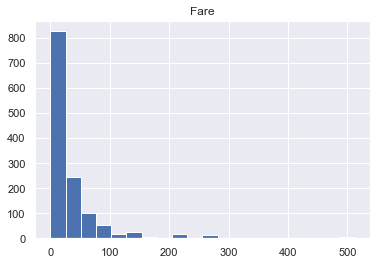

In [16]:
# display histograms for numeric features
for i in numeric_features:
    plt.hist(common_data[i], bins = 20)
    plt.title(i)
    plt.show()

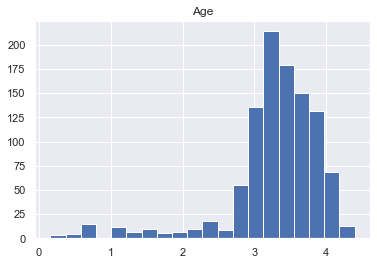

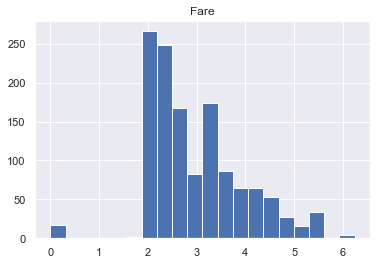

In [17]:
for i in numeric_features:
    common_data[i + '_log'] = common_data[i].apply(np.log1p)
    plt.hist(common_data[i + '_log'], bins = 20)
    plt.title(i)
    plt.show()

<AxesSubplot:xlabel='Age', ylabel='Fare'>

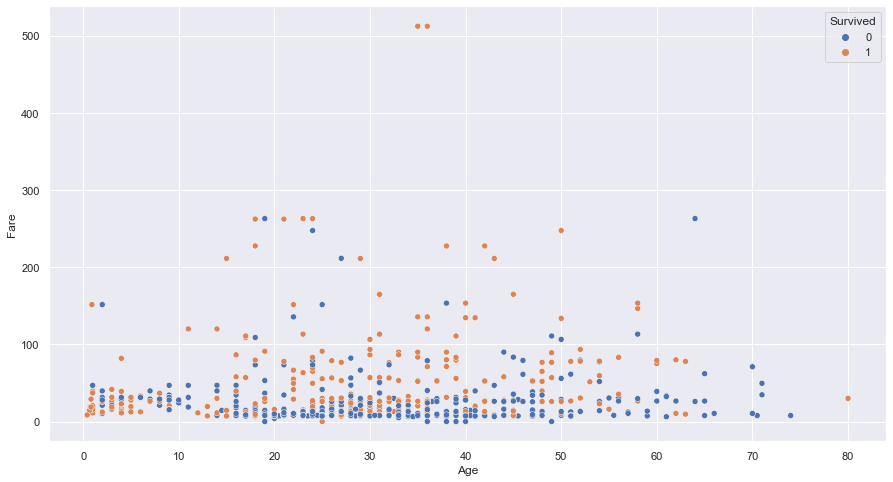

In [18]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = train_data, x = 'Age', y = 'Fare', hue = y)

In [19]:
# compare survival rate across numeric features
pd.pivot_table(train_data, index = y, values = numeric_features)

,Age,Fare
Survived,,
0,30.626179,22.117887
1,28.343690,48.395408


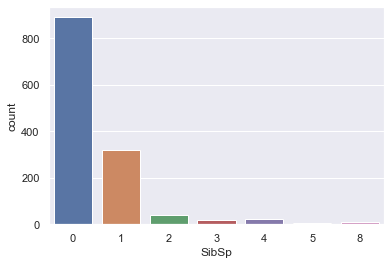

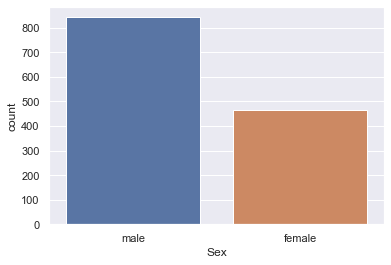

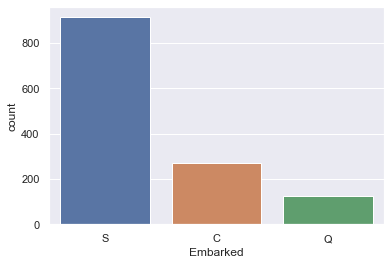

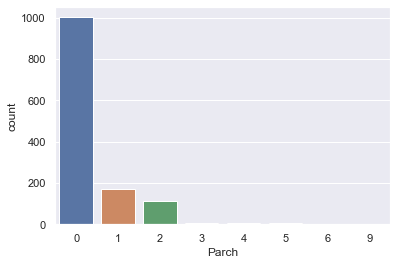

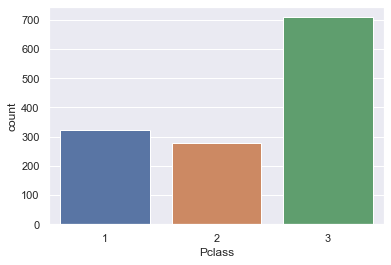

In [20]:
# display barplots for categorical features
for i in categorical_features:
    sns.countplot(x = common_data[i])
    plt.show()

In [21]:
# convert 'Name' feature into categorical one
common_data['Name_cat'] = common_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
common_data['Name_cat'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Mme               1
Don               1
the Countess      1
Lady              1
Sir               1
Dona              1
Capt              1
Jonkheer          1
Name: Name_cat, dtype: int64

In [22]:
# there are three big groups: Mr, Miss, Mrs. Combine others into 'Other' category
common_data['Name_cat'] = common_data['Name_cat'].apply(lambda x : x if x in ['Mr', 'Miss', 'Mrs'] else 'Other')
common_data['Name_cat'].value_counts()

Mr       757
Miss     260
Mrs      197
Other     95
Name: Name_cat, dtype: int64

In [23]:
common_data.drop('Name', axis = 1, inplace = True)
common_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train,Age_log,Fare_log,Name_cat
0,3,male,22.0,1,0,7.2500,S,1,3.135494,2.110213,Mr
1,1,female,38.0,1,0,71.2833,C,1,3.663562,4.280593,Mrs
2,3,female,26.0,0,0,7.9250,S,1,3.295837,2.188856,Miss
3,1,female,35.0,1,0,53.1000,S,1,3.583519,3.990834,Mrs
4,3,male,35.0,0,0,8.0500,S,1,3.583519,2.202765,Mr


In [24]:
# what features should be filled in train_data
common_data[common_data['train'] == 1].isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
train         0
Age_log     177
Fare_log      0
Name_cat      0
dtype: int64

In [25]:
# what features should be filled in test_data
common_data[common_data['train'] == 0].isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
train        0
Age_log     86
Fare_log     1
Name_cat     0
dtype: int64

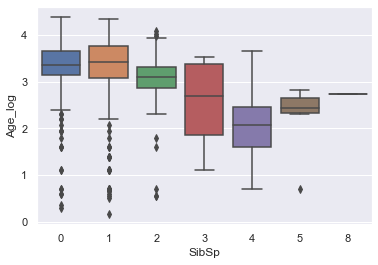

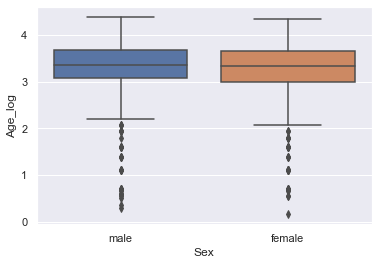

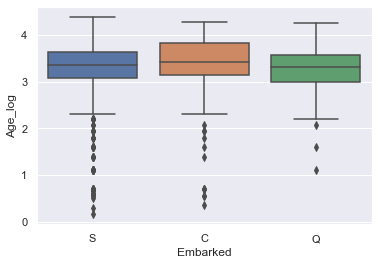

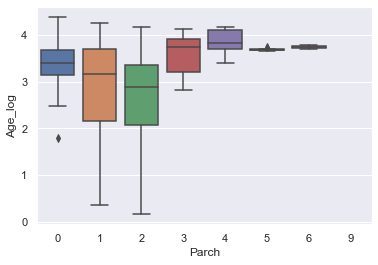

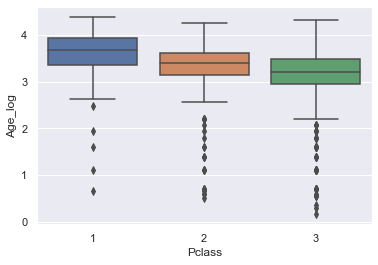

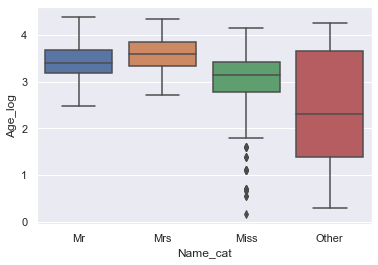

In [26]:
# there are a lot of null values in 'Age' feature
# let's check how this feature correlated with others
categorical_features.append('Name_cat')

for i in categorical_features:
    sns.boxplot(data = common_data, x = i, y = 'Age_log', orient = 'v')
    plt.show()

It seems it makes sense to fill in 'Age' empty values according to the 'Name_cat' feature ('Patch' feature looks better but there are no 'Age' values for Patch = 9!)

In [27]:
#remove 2 null values of 'Embarked' feature
ids = common_data[pd.isna(common_data['Embarked'])].index
y.drop(labels = ids, inplace = True)
common_data.drop(labels = ids, axis = 0, inplace = True)

In [28]:
#age
from scipy.stats import trim_mean
common_data['Age_log'].fillna(common_data.groupby('Name_cat')['Age_log'].transform(lambda x: trim_mean(x.dropna(), 0.05)), inplace = True)
common_data['Age_log'].isna().sum()

0

In [29]:
#fare (use median because 'Fare' feature distribution is not normal)
common_data[pd.isna(common_data['Fare_log'])]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train,Age_log,Fare_log,Name_cat
1043,3,male,60.5,0,0,NaN,S,0,4.119037,NaN,Mr


<AxesSubplot:xlabel='Pclass', ylabel='Fare_log'>

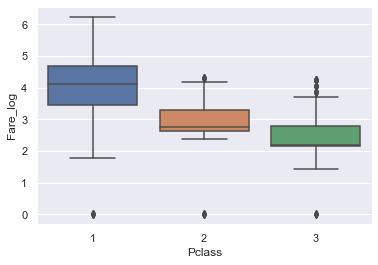

In [30]:
sns.boxplot(data = common_data, x = 'Pclass', y = 'Fare_log', orient = 'v')

In [31]:
common_data['Fare_log'].fillna(common_data[common_data['Pclass'] == 3]['Fare_log'].median(), inplace = True) 

In [32]:
common_data.drop(columns = numeric_features, inplace = True)
common_data

,Pclass,Sex,SibSp,Parch,Embarked,train,Age_log,Fare_log,Name_cat
0,3,male,1,0,S,1,3.135494,2.110213,Mr
1,1,female,1,0,C,1,3.663562,4.280593,Mrs
2,3,female,0,0,S,1,3.295837,2.188856,Miss
3,1,female,1,0,S,1,3.583519,3.990834,Mrs
4,3,male,0,0,S,1,3.583519,2.202765,Mr
...,...,...,...,...,...,...,...,...,...
1304,3,male,0,0,S,0,3.433319,2.202765,Mr
1305,1,female,0,0,C,0,3.688879,4.699571,Other
1306,3,male,0,0,S,0,3.676301,2.110213,Mr
1307,3,male,0,0,S,0,3.433319,2.202765,Mr


In [33]:
common_data.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
train       0
Age_log     0
Fare_log    0
Name_cat    0
dtype: int64

In [34]:
common_data[categorical_features] = common_data[categorical_features].astype('category')
data_dummies = pd.get_dummies(common_data, drop_first = True)
data_dummies

,train,Age_log,Fare_log,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S,Name_cat_Mr,Name_cat_Mrs,Name_cat_Other
0,1,3.135494,2.110213,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,3.663562,4.280593,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,3.295837,2.188856,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,3.583519,3.990834,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,3.583519,2.202765,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3.433319,2.202765,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1305,0,3.688879,4.699571,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1306,0,3.676301,2.110213,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1307,0,3.433319,2.202765,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [35]:
X_train = data_dummies[data_dummies['train'] == 1]
X_test = data_dummies[data_dummies['train'] == 0]

In [36]:
X_train.pop('train')
X_train.head()

,Age_log,Fare_log,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S,Name_cat_Mr,Name_cat_Mrs,Name_cat_Other
0,3.135494,2.110213,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,3.663562,4.280593,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3.295837,2.188856,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3.583519,3.990834,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,3.583519,2.202765,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [37]:
X_test.pop('train')
X_test.head()

,Age_log,Fare_log,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S,Name_cat_Mr,Name_cat_Mrs,Name_cat_Other
891,3.569533,2.178064,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
892,3.871201,2.079442,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
893,4.143135,2.369075,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
894,3.332205,2.268252,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
895,3.135494,2.586824,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [38]:
# standartization
numeric_features = ['Age_log', 'Fare_log']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])

X_test.head()

C:\Users\0x17h\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\0x17h\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Age_log,Fare_log,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S,Name_cat_Mr,Name_cat_Mrs,Name_cat_Other
891,0.480933,-0.807439,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
892,0.965467,-0.909406,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
893,1.402241,-0.609952,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
894,0.099742,-0.714193,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
895,-0.216211,-0.384820,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


## Model

### Logistic regression

In [39]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y)
lr.score(X_train, y)

0.8256467941507312

In [40]:
pd.DataFrame({'features' : X_train.columns, 'coef' : lr.coef_[0]})

,features,coef
0,Age_log,-0.525171
1,Fare_log,0.218761
2,Pclass_2,-0.755894
3,Pclass_3,-1.705085
4,Sex_male,-1.507083
5,SibSp_1,-0.090499
6,SibSp_2,-0.333785
7,SibSp_3,-1.446446
8,SibSp_4,-1.461700
9,SibSp_5,-1.053707


In [41]:
# only in test dataset!
common_data[common_data.Parch == 9]

,Pclass,Sex,SibSp,Parch,Embarked,train,Age_log,Fare_log,Name_cat
1233,3,male,1,9,S,0,3.433319,4.256322,Mr
1256,3,female,1,9,S,0,3.580323,4.256322,Mrs


### Random Forest

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
parameters = {'n_estimators': range(10, 500, 50), 
              'max_features': range(2, X_train.shape[1] + 1, 2), 
              'max_depth': [5, 10, 20, 50]}

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = GridSearchCV(RandomForestClassifier(random_state = 42), parameters)
rf.fit(X_train, y)
rf.best_score_, rf.best_params_

(0.8380371992636324,
 {'max_depth': 10, 'max_features': 16, 'n_estimators': 360})

### SVM

In [45]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'nu': np.arange(0.3, 0.8, 0.2), 
              'degree': [2, 3, 5], 
              'gamma' : ['scale', 'auto']}

In [46]:
from sklearn import svm

svm = GridSearchCV(svm.NuSVC(random_state = 42), parameters)
svm.fit(X_train, y)
svm.best_score_, svm.best_params_

(0.8177870881736812,
 {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.5})

In [47]:
rf_pred = rf.best_estimator_.predict(X_test).astype(int)
lr_pred = lr.predict(X_test).astype(int)
svm_pred = svm.best_estimator_.predict(X_test).astype(int)

In [48]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': lr_pred})
output.to_csv('lr_submission.csv', index = False)

In [49]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': rf_pred})
output.to_csv('rf_submission.csv', index = False)

In [50]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': svm_pred})
output.to_csv('svm_submission.csv', index = False)